# Henny Penny Image Processing System

This system is designed using transfer learning on the pre-trained [MobileNet](https://ai.googleblog.com/2017/06/mobilenets-open-source-models-for.html) image classification system. The code re-trains the MobileNet system to recognize four distinct food types


1.   Chicken nuggets
2.   Chicken patties
3.   Hash browns
4.   Shoestring fries

System takes approximately 1.5 hours to train on a dataset with 20,000 images and completes with an accuracy rate of 100% with a cost approximation (loss) in the order of $10^{-5}$.





# Algorithm Description



This system is trained primarily using TensorFlow 1.x (default is 1.15), which is depreciated. Most functions used are still present in TensorFlow 2.x, so once the system is trained, it will work in any version of TensorFlow. The only thing that will have to be ensured on the product is that version 2.10.0 of h5py is used, using a different version will cause the function used to load the system to bug. This version can be force installed using the below pip command.

In [1]:
!pip install 'h5py == 2.10.0' --force-reinstall

     |████████████████████████████████| 2.9 MB 5.3 MB/s 
     |████████████████████████████████| 15.7 MB 24.2 MB/s 
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

The code below checks the system settings and loads the dataset from the proper Drive folder. The output from the settings should look as follows:


```
Version: 1.15.2
Hub Version: 0.12.0
h5py Version: 2.10.0
Eager Mode: False
GPU is AVAILABLE
```
The data is loaded in and sorted using the included TensorFlow class ImageDataGenerator. This takes care of the load, the training/validation split, and label creation. The validation split is currently set to 20%, but can be changed if desired.

In order for the system to run, the output batch size for the images should read

```
Image Batch Shape: (32, 224, 224, 3)
```
In the final section of this code block, the system is built and trained. The system uses the pre-trained MobileNet system and performs transfer learning to fit it to the desired dataset. 


In [2]:
%tensorflow_version 1.x

import os
import sys
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import h5py

from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import drive

pd.set_option("display.precision", 8)
print("Version:", tf.__version__)
print("Hub Version:", hub.__version__)
print("h5py Version:", h5py.__version__)
print("Eager Mode:", tf.executing_eagerly())
print("GPU is", "AVAILABLE" if tf.test.is_gpu_available() else "UNAVAILABLE")

drive.mount('/content/drive')

ROOT = '/content/drive/My Drive/HPImageProcessing/dataset'
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(ROOT)
print(TRAINING_DATA_DIR)

datagen_kwargs = dict(rescale=1./255, validation_split=0.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(TRAINING_DATA_DIR, 
                                                    subset="validation",
                                                    shuffle=True,
                                                    target_size=IMAGE_SHAPE)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(TRAINING_DATA_DIR,
                                                    subset="training",
                                                    shuffle=True,
                                                    target_size=IMAGE_SHAPE)

image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape:", image_batch_train.shape)
print("Label batch shape:", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair: pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

model = tf.keras.Sequential([hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
                                            output_shape=[1280],
                                            trainable=False),
                             tf.keras.layers.Dropout(0.4),
                             tf.keras.layers.Dense(train_generator.num_classes,
                                                   activation='softmax')])

model.build([None, 224, 224, 3])
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)

hist = model.fit(train_generator,
                 epochs=10,
                 verbose=1,
                 steps_per_epoch=steps_per_epoch,
                 validation_data=valid_generator,
                 validation_steps=val_steps_per_epoch).history


TensorFlow 1.x selected.
Version: 1.15.2
Hub Version: 0.12.0
h5py Version: 2.10.0
Eager Mode: False
GPU is AVAILABLE
Mounted at /content/drive
/content/drive/My Drive/HPImageProcessing/dataset
Found 4000 images belonging to 4 classes.
Found 16012 images belonging to 4 classes.
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 4)
['Chicken_Nuggets' 'Chicken_Patties' 'Hash_Browns' 'Shoestring_Fries']
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/10


501/501 [==============================] - 3632s 7s/step - loss: 0.0480 - acc: 0.9380 - val_loss: 0.0010 - val_acc: 1.0000
Epoch 2/10
501/501 [==============================] - 55s 109ms/step - loss: 0.0015 - acc: 1.0000 - val_loss: 4.1240e-04 - val_acc: 1.0000
Epoch 3/10
501/501 [==============================] - 54s 109ms/step - loss: 6.4397e-04 - acc: 1.0000 - val_loss: 1.7422e-04 - val_acc: 1.0000
Epoch 4/10
501/501 [==============================] - 54s 108ms/step - loss: 3.5297e-04 - acc: 1.0000 - val_loss: 1.0201e-04 - val_acc: 1.0000
Epoch 5/10
501/501 [==============================] - 54s 107ms/step - loss: 2.0439e-04 - acc: 1.0000 - val_loss: 7.0000e-05 - val_acc: 1.0000
Epoch 6/10
501/501 [==============================] - 54s 108ms/step - loss: 1.4077e-04 - acc: 1.0000 - val_loss: 4.9744e-05 - val_acc: 1.0000
Epoch 7/10
501/501 [==============================] - 54s 107ms/step - loss: 1.0546e-04 - acc: 1.0000 - val_loss: 3.5770e-05 - val_acc: 1.0000
Epoch 8/10
501/501 [===

# Testing, Saving, and Loading the System


The system is tested on the validation set partitioned in the previous step. A selection of results are output in a chart for human validation. 

Validation batch shape: (32, 224, 224, 3)
Prediciton results for the first elements


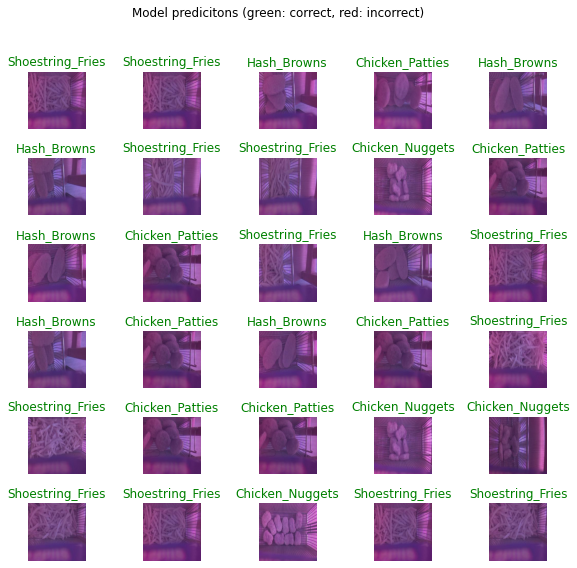

In [3]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_labels_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediciton results for the first elements")
tf_pred_dataframe.head()

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_labels_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predicitons (green: correct, red: incorrect)")

As a second check to the check performed above, the accuracy of the system is calculated.

In [4]:
wrong = 0
for i in range(32):
  if predicted_ids[i] == true_labels_ids[i]:
    wrong += 1

print("Accuracy (%):", wrong/len(tf_model_predictions)*100)

Accuracy (%): 100.0


The model is saved to the desired directory using the TensorFlow function save_model(). This will save the trained model (all weight and biases) in a file that can be loaded either back into this script, or into a different one. The file is then loaded back in here to verify the save was succesful.

In [5]:
SAVED_MODEL = '/content/drive/My Drive/HPImageProcessing/food'
tf.keras.models.save_model(model, SAVED_MODEL, overwrite=True)
test_model = tf.keras.models.load_model(SAVED_MODEL, custom_objects={'KerasLayer': hub.KerasLayer})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Finally, the loaded model is tested again to ensure no functionality was lost during either the save or the load.

Validation batch shape: (32, 224, 224, 3)


Prediciton results for the first elements


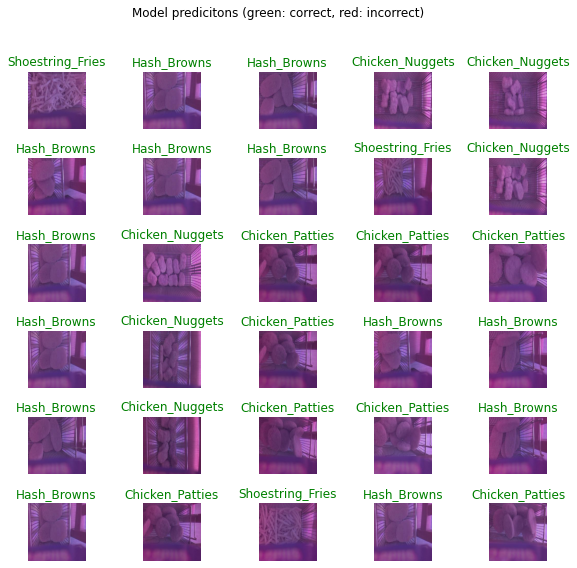

In [6]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_labels_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

tf_model_predictions = test_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediciton results for the first elements")
tf_pred_dataframe.head()

predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6, 5, n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_labels_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predicitons (green: correct, red: incorrect)")

As can be seen from the training and loss graphs below, using transfer learning allowed the system to reach maximum efficiency quite quickly. This system could most likely be trained on a much smaller dataset than the one used.

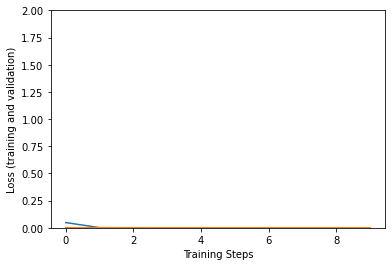

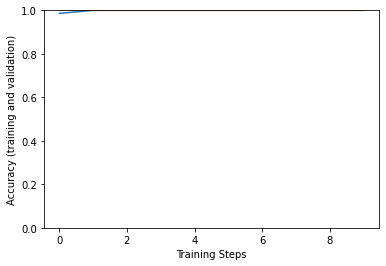

In [7]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])